# 😴 Multi-Day Sleep Analysis with Heart Rate Correlation

Comprehensive sleep analysis supporting both single-day and multi-day analysis with heart rate correlation.

## Features
- **Single Day Analysis**: Detailed sleep stages, efficiency, naps
- **Multi-Day Trends**: Sleep quality, duration, and patterns over time
- **Heart Rate Integration**: HR during sleep, recovery metrics, correlations
- **FAST Loading**: Uses optimized partitioned Parquet structure

## How to Use
1. Set analysis mode: `'single'` or `'multi'`
2. Set date(s) in configuration section
3. Run all cells
4. View comprehensive sleep analysis

## Data Source
- **Structure**: `../data/` (partitioned parquet files)
- **Update**: Run `./update_fitbit_data.sh` to refresh data

---
## 📋 Configuration

In [19]:
# ===== ANALYSIS MODE =====
ANALYSIS_MODE = 'single'  # 'single' or 'multi'

# ===== SINGLE DAY CONFIGURATION =====
TARGET_DATE = '2025-12-13'  # Date to analyze (YYYY-MM-DD)

# ===== MULTI-DAY CONFIGURATION =====
START_DATE = '2025-12-01'   # Start date (YYYY-MM-DD)
END_DATE = '2025-12-04'     # End date (YYYY-MM-DD)

# ===== DATA CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Analysis Mode: {ANALYSIS_MODE}")
if ANALYSIS_MODE == 'single':
    print(f"  Target Date: {TARGET_DATE}")
else:
    print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Data Directory: {PARQUET_PATH}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Analysis Mode: single
  Target Date: 2025-12-13
  Data Directory: ../data
  Timezone: Europe/London


---
## 📦 Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


---
## 🔧 Data Loading Functions

In [21]:
# Measurement categorization
HIGH_FREQUENCY_INTRADAY = {
    'HeartRate_Intraday': 'heartrate_intraday',
    'Steps_Intraday': 'steps_intraday'
}

MODERATE_FREQUENCY = {
    'GPS': 'gps.parquet',
    'SleepLevels': 'sleep_levels.parquet'
}


def clean_column_names(df):
    """Remove field_ and tag_ prefixes from column names."""
    rename_dict = {}
    for col in df.columns:
        if col.startswith('field_'):
            rename_dict[col] = col.replace('field_', '')
        elif col.startswith('tag_'):
            rename_dict[col] = col.replace('tag_', '')

    if rename_dict:
        df = df.rename(columns=rename_dict)

    return df


def load_single_date_from_parquet(date_str, parquet_path='../data', timezone='Europe/London'):
    """
    Load Fitbit data for a single date from PARTITIONED Parquet structure.
    
    For sleep data: Also checks previous day's sleep sessions that extend into target date.
    
    Args:
        date_str: Date in format 'YYYY-MM-DD'
        parquet_path: Path to data directory
        timezone: Timezone for date filtering
    
    Returns:
        dict: {'HeartRate_Intraday': df, 'SleepSummary': df, ...}
    """
    data_dir = Path(parquet_path)
    dfs = {}
    target_date = pd.to_datetime(date_str).date()
    prev_date = (pd.to_datetime(date_str) - pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    # Load HIGH-FREQUENCY INTRADAY data (date-partitioned)
    for measurement, dir_name in HIGH_FREQUENCY_INTRADAY.items():
        dir_path = data_dir / dir_name
        if not dir_path.exists():
            continue

        try:
            df = pd.read_parquet(dir_path, filters=[('date', '=', date_str)])
            if not df.empty:
                df = clean_column_names(df)
                if pd.api.types.is_datetime64_any_dtype(df['time']):
                    if df['time'].dt.tz is None:
                        df['time'] = df['time'].dt.tz_localize('UTC')
                dfs[measurement] = df
        except Exception as e:
            print(f"   ⚠️  Error loading {measurement}: {e}")

    # Load MODERATE-FREQUENCY data
    for measurement, filename in MODERATE_FREQUENCY.items():
        file_path = data_dir / filename
        if not file_path.exists():
            continue

        try:
            df = pd.read_parquet(file_path)
            if 'date' in df.columns:
                df = df[df['date'] == date_str]
            elif 'time' in df.columns:
                if pd.api.types.is_datetime64_any_dtype(df['time']):
                    if df['time'].dt.tz is None:
                        df['time'] = df['time'].dt.tz_localize('UTC')
                    start_datetime = pd.Timestamp(target_date).tz_localize(timezone)
                    end_datetime = start_datetime + pd.Timedelta(days=1)
                    start_utc = start_datetime.tz_convert('UTC')
                    end_utc = end_datetime.tz_convert('UTC')
                    df = df[(df['time'] >= start_utc) & (df['time'] < end_utc)]

            if not df.empty:
                df = clean_column_names(df)
                dfs[measurement] = df
        except Exception as e:
            print(f"   ⚠️  Error loading {measurement}: {e}")

    # Load DAILY SUMMARIES (special handling for sleep)
    daily_file = data_dir / 'daily_summaries.parquet'
    if daily_file.exists():
        try:
            df_daily = pd.read_parquet(daily_file)
            
            # For sleep data, also check previous day for overnight sleep
            if 'date' in df_daily.columns:
                # Get data for target date and previous date
                df_daily_filtered = df_daily[
                    (df_daily['date'] == date_str) | 
                    (df_daily['date'] == prev_date)
                ].copy()
                
                # For SleepSummary measurements, filter by endTime extending into target date
                if not df_daily_filtered.empty and 'measurement' in df_daily_filtered.columns:
                    df_daily_filtered = clean_column_names(df_daily_filtered)
                    
                    for measurement in df_daily_filtered['measurement'].unique():
                        df_meas = df_daily_filtered[df_daily_filtered['measurement'] == measurement].copy()
                        
                        # Special handling for SleepSummary: check if sleep extends into target date
                        if measurement == 'SleepSummary' and 'endTime' in df_meas.columns:
                            # Parse endTime and filter
                            df_meas['endTime_parsed'] = pd.to_datetime(df_meas['endTime'])
                            target_start = pd.Timestamp(target_date).tz_localize('UTC')
                            target_end = target_start + pd.Timedelta(days=1)
                            
                            # Keep sleep sessions that:
                            # 1. Start on target date, OR
                            # 2. End on or after target date (overnight sleep from previous day)
                            df_meas = df_meas[
                                (df_meas['date'] == date_str) |
                                (df_meas['endTime_parsed'] >= target_start)
                            ]
                            
                            # Drop the helper column
                            if 'endTime_parsed' in df_meas.columns:
                                df_meas = df_meas.drop(columns=['endTime_parsed'])
                        else:
                            # For non-sleep measurements, only keep target date
                            df_meas = df_meas[df_meas['date'] == date_str]
                        
                        if not df_meas.empty:
                            df_meas = df_meas.drop(columns=['measurement'])
                            dfs[measurement] = df_meas
                            
            elif 'time' in df_daily.columns:
                # Fallback: filter by time
                if pd.api.types.is_datetime64_any_dtype(df_daily['time']):
                    if df_daily['time'].dt.tz is None:
                        df_daily['time'] = df_daily['time'].dt.tz_localize('UTC')
                    start_datetime = pd.Timestamp(target_date).tz_localize(timezone)
                    end_datetime = start_datetime + pd.Timedelta(days=1)
                    start_utc = start_datetime.tz_convert('UTC')
                    end_utc = end_datetime.tz_convert('UTC')
                    df_daily = df_daily[(df_daily['time'] >= start_utc) & (df_daily['time'] < end_utc)]

                if not df_daily.empty and 'measurement' in df_daily.columns:
                    df_daily = clean_column_names(df_daily)
                    for measurement in df_daily['measurement'].unique():
                        df_meas = df_daily[df_daily['measurement'] == measurement].copy()
                        df_meas = df_meas.drop(columns=['measurement'])
                        dfs[measurement] = df_meas
        except Exception as e:
            print(f"   ⚠️  Error loading daily summaries: {e}")

    return dfs


def load_date_range_from_parquet(start_date, end_date, parquet_path='../data', timezone='Europe/London'):
    """
    Load Fitbit data for a date range.
    
    Args:
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        parquet_path: Path to data directory
        timezone: Timezone for date filtering
    
    Returns:
        dict: {'HeartRate_Intraday': df, 'SleepSummary': df, ...} with multi-day data
    """
    print(f"📥 Loading data for {start_date} to {end_date}...")
    
    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    date_strs = [d.strftime('%Y-%m-%d') for d in dates]
    
    all_dfs = {}
    
    for date_str in date_strs:
        day_dfs = load_single_date_from_parquet(date_str, parquet_path, timezone)
        
        # Combine with existing data
        for measurement, df in day_dfs.items():
            if measurement not in all_dfs:
                all_dfs[measurement] = []
            all_dfs[measurement].append(df)
    
    # Concatenate all dataframes
    combined_dfs = {}
    for measurement, df_list in all_dfs.items():
        if df_list:
            combined_df = pd.concat(df_list, ignore_index=True)
            # Remove duplicates (e.g., same sleep session appearing in multiple days)
            if 'time' in combined_df.columns:
                combined_df = combined_df.drop_duplicates(subset=['time'], keep='first')
            combined_dfs[measurement] = combined_df
    
    total_memory_mb = sum(df.memory_usage(deep=True).sum() for df in combined_dfs.values()) / 1024 / 1024
    print(f"   ✅ Loaded {len(combined_dfs)} measurement types")
    print(f"   💾 Memory used: {total_memory_mb:.1f} MB")
    
    return combined_dfs


print("✅ Data loading functions defined")

✅ Data loading functions defined


---
## 📥 Load Data

In [22]:
# Load data based on analysis mode
if ANALYSIS_MODE == 'single':
    dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {TARGET_DATE}:")
else:
    dfs = load_date_range_from_parquet(START_DATE, END_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {START_DATE} to {END_DATE}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

# Extract common DataFrames
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_sleep_levels = dfs.get('SleepLevels', pd.DataFrame())
df_sleep_summary = dfs.get('SleepSummary', pd.DataFrame())
df_hrv = dfs.get('HRV', pd.DataFrame())
df_resting_hr = dfs.get('RestingHR', pd.DataFrame())
df_breathing_rate = dfs.get('BreathingRate', pd.DataFrame())

print(f"\n✅ Data loaded successfully")


📊 Data Summary for 2025-12-13:
HeartRate_Intraday             |  36572 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     52 records
DeviceBatteryLevel             |      1 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
SleepSummary                   |      1 records
ActivityRecords                |      1 records

✅ Data loaded successfully


---
## 🛠️ Sleep Analysis Functions

In [23]:
# ============================================================================
# SLEEP ANALYSIS CONSTANTS & HELPER FUNCTIONS
# ============================================================================

# Color scheme for sleep stages
SLEEP_COLORS = {
    'Deep': '#0f172a',      # Midnight Navy
    'Light': '#a5d8ff',     # Pastel Blue
    'REM': '#c084fc',       # Soft Lavender
    'Awake': '#fde047'      # Butter Yellow
}

# Map numeric levels to names
LEVEL_DECODE = {
    0: 'Deep',
    1: 'Light',
    2: 'REM',
    3: 'Awake'
}


def _get_main_sleep_session(df_summary):
    """Extract the main sleep session from summary dataframe."""
    if df_summary.empty:
        return None
    
    summary = df_summary.copy()
    if 'isMainSleep' in summary.columns:
        main_sleep = summary[summary['isMainSleep'] == 'True']
        if not main_sleep.empty:
            summary = main_sleep
    
    return summary.iloc[0]


def _prepare_sleep_data(df_levels, df_summary, start_time, end_time):
    """
    Prepare sleep level data for a time window.
    Adds Awake periods at the start, between sessions, and at the end.
    """
    levels = df_levels.copy()
    levels['time'] = levels['time'].dt.tz_convert(TIMEZONE)
    levels['end_time'] = levels['end_time'].dt.tz_convert(TIMEZONE)
    
    levels = levels[
        (levels['time'] >= start_time) & 
        (levels['time'] < end_time)
    ].copy()
    
    if levels.empty:
        return levels
    
    levels = levels.sort_values('time').reset_index(drop=True)
    
    summary = df_summary.copy()
    summary['time'] = summary['time'].dt.tz_convert(TIMEZONE)
    summary['end_time'] = summary['end_time'].dt.tz_convert(TIMEZONE)
    summary = summary.sort_values('time').reset_index(drop=True)
    
    gaps_to_add = []
    
    # Add Awake period from start_time to first sleep session
    if not summary.empty:
        first_session_start = summary['time'].min()
        if start_time < first_session_start:
            gap_seconds = (first_session_start - start_time).total_seconds()
            if gap_seconds > 60:
                gaps_to_add.append({
                    'time': start_time,
                    'end_time': first_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Check if stages data ends before session end_time
    for idx, session in summary.iterrows():
        session_start = session['time']
        session_end = session['end_time']
        
        session_stages = levels[
            (levels['time'] >= session_start) & 
            (levels['time'] < session_end)
        ]
        
        if not session_stages.empty:
            last_stage_end = session_stages['end_time'].max()
            if last_stage_end < session_end:
                gap_seconds = (session_end - last_stage_end).total_seconds()
                if gap_seconds > 30:
                    gaps_to_add.append({
                        'time': last_stage_end,
                        'end_time': session_end,
                        'level': 3.0,
                        'level_name': 'Awake',
                        'duration_seconds': gap_seconds,
                        'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                    })
    
    # Find gaps BETWEEN sessions
    for i in range(len(summary) - 1):
        current_session_end = summary.iloc[i]['end_time']
        next_session_start = summary.iloc[i + 1]['time']
        
        if current_session_end < next_session_start:
            gap_seconds = (next_session_start - current_session_end).total_seconds()
            if gap_seconds > 60:
                gaps_to_add.append({
                    'time': current_session_end,
                    'end_time': next_session_start,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    # Add Awake period from last session to end_time
    if not summary.empty:
        last_session_end = summary['end_time'].max()
        if last_session_end < end_time:
            gap_seconds = (end_time - last_session_end).total_seconds()
            if gap_seconds > 60:
                gaps_to_add.append({
                    'time': last_session_end,
                    'end_time': end_time,
                    'level': 3.0,
                    'level_name': 'Awake',
                    'duration_seconds': gap_seconds,
                    'Device': levels['Device'].iloc[0] if 'Device' in levels.columns else 'PixelWatch3',
                })
    
    if gaps_to_add:
        levels = pd.concat([levels, pd.DataFrame(gaps_to_add)], ignore_index=True)
        levels = levels.sort_values('time').reset_index(drop=True)
    
    return levels


def _plot_sleep_bars(ax, levels):
    """Plot horizontal bars for sleep stages."""
    seen_labels = set()

    for idx, row in levels.iterrows():
        stage = row['level_name']
        color = SLEEP_COLORS.get(stage, '#cccccc')
        duration_hours = row['duration_seconds'] / 3600
        
        label = stage if stage not in seen_labels else None
        seen_labels.add(stage)

        ax.barh(
            y=0,
            width=duration_hours,
            left=row['time'],
            height=0.8,
            color=color,
            # edgecolor='white',
            # linewidth=0.5,
            alpha=0.9,
            label=label
        )


def _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15):
    """Apply common formatting to timeline axis."""
    formatter = DateFormatter('%H:%M', tz=start_time.tz)
    ax.xaxis.set_major_formatter(formatter)
    
    time_span_hours = (end_time - start_time).total_seconds() / 3600
    
    if time_span_hours > 6:
        ax.xaxis.set_major_locator(HourLocator(interval=1, tz=start_time.tz))
    elif time_span_hours > 2:
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, 30), tz=start_time.tz))
    else:
        ax.xaxis.set_major_locator(MinuteLocator(byminute=range(0, 60, interval_minutes), tz=start_time.tz))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.set_xlim(start_time, end_time)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


def _add_sleep_legend(ax, location='upper right'):
    """Add standard sleep stage legend to axis."""
    legend_elements = [
        mpatches.Patch(facecolor=SLEEP_COLORS['Deep'], label='Deep', edgecolor='orange'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Light'], label='Light', edgecolor='orange'),
        mpatches.Patch(facecolor=SLEEP_COLORS['REM'], label='REM', edgecolor='orange'),
        mpatches.Patch(facecolor=SLEEP_COLORS['Awake'], label='Awake', edgecolor='orange')
    ]
    ax.legend(handles=legend_elements, loc=location, ncol=4, fontsize=11, framealpha=0.9)


print("✅ Sleep helper functions defined")

✅ Sleep helper functions defined


---
## 📊 Sleep Visualization Functions

In [24]:
# ============================================================================
# SINGLE-DAY SLEEP VISUALIZATIONS
# ============================================================================

def plot_sleep_timeline(df_levels, df_summary):
    """Plot horizontal timeline showing sleep stages for a single day."""
    if df_levels.empty or df_summary.empty:
        print(f"❌ No sleep data found")
        return None

    main_sleep = df_summary[df_summary.get('isMainSleep', 'True') == 'True']
    if main_sleep.empty:
        main_sleep = df_summary.iloc[[0]]

    main_sleep_start = main_sleep.iloc[0]['time']
    sleep_hour = main_sleep_start.hour
    actual_date = main_sleep_start.date()

    if sleep_hour >= 18:
        sleep_date = actual_date
    elif sleep_hour < 6:
        sleep_date = (main_sleep_start - pd.Timedelta(days=1)).date()
    else:
        sleep_date = actual_date

    main_sleep_end = (
        main_sleep.iloc[0].get("endTime") or
        main_sleep.iloc[0].get("end_time") or
        None
    )
    if main_sleep_end is not None:
        main_sleep_end = pd.to_datetime(main_sleep_end)

    if sleep_hour < 18:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "midnight-to-midnight"
    else:
        start_time = pd.Timestamp(actual_date, tz=TIMEZONE) + pd.Timedelta(hours=12)
        end_time = start_time + pd.Timedelta(days=1)
        window_type = "noon-to-noon"

    print(f"   📅 Sleep Date: {sleep_date.strftime('%A %dth %B %Y')}")
    print(f"   🌙 To Bed: {main_sleep_start.strftime('%H:%M on %A %dth %B')}")
    if main_sleep_end is not None:
        print(f"   ☀️ Woke Up: {main_sleep_end.strftime('%H:%M on %A %dth %B')}\n")

    levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)
    if levels.empty:
        print(f"❌ No sleep level data found")
        return None

    fig, ax = plt.subplots(figsize=(16, 4))
    _plot_sleep_bars(ax, levels)

    ax.axvline(main_sleep_start, linestyle="--", linewidth=1.2)
    ax.text(main_sleep_start, 1.05, "To Bed", ha="center", va="bottom",
            fontsize=10, transform=ax.get_xaxis_transform())

    if main_sleep_end is not None:
        ax.axvline(main_sleep_end, linestyle="--", linewidth=1.2)
        ax.text(main_sleep_end, 1.05, "Up", ha="center", va="bottom",
                fontsize=10, transform=ax.get_xaxis_transform())

    if window_type == "noon-to-noon":
        day1 = start_time.date()
        day2 = end_time.date()
        title = (
            f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'
            f'({day1.strftime("%a %d %b")} noon → {day2.strftime("%a %d %b")} noon)\n'
        )
    else:
        title = f'Sleep stages for {sleep_date.strftime("%A %dth %B %Y")}\n'

    _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=60)
    _add_sleep_legend(ax, location='upper left' if window_type == 'noon-to-noon' else 'upper right')

    plt.tight_layout()
    return fig


def plot_sleep_stages_pie(df_levels, df_summary):
    """Plot pie chart showing sleep stage distribution."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    start_time = summary['time'].tz_convert(TIMEZONE)
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    stage_minutes = pd.Series(stage_minutes)
    non_awake = stage_minutes.sum() - stage_minutes.get('Awake', 0)
    hours_asleep = round(non_awake / 60, 2)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    colors_ordered = [SLEEP_COLORS[stage] for stage in stage_minutes.index]
    
    wedges, texts, autotexts = ax.pie(
        stage_minutes,
        labels=[f'{stage}\n{mins:.0f} min' for stage, mins in stage_minutes.items()],
        autopct='%1.1f%%',
        colors=colors_ordered,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        explode=[0.05] * len(stage_minutes)
    )
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
    
    ax.set_title(
        f'Sleep Stage Distribution for {sleep_date.strftime("%A %dth %B %Y")}\n\nTotal Sleep: {hours_asleep} hrs (excluding Awake)\n',
        fontsize=14,
        fontweight='bold',
        pad=12
    )
    
    plt.tight_layout()
    return fig


def plot_sleep_stages_bar(df_summary):
    """Plot stacked bar showing hours of each sleep stage."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    stage_minutes = {
        'Deep': summary.get('minutesDeep', 0),
        'Light': summary.get('minutesLight', 0),
        'REM': summary.get('minutesREM', 0),
        'Awake': summary.get('minutesAwake', 0)
    }
    
    stage_hours = {stage: mins / 60 for stage, mins in stage_minutes.items()}
    time_asleep = stage_hours['Deep'] + stage_hours['Light'] + stage_hours['REM']
    time_in_bed = summary['minutesInBed'] / 60
    
    fig, ax = plt.subplots(figsize=(6, 10))
    
    stage_order = ['Deep', 'Light', 'REM', 'Awake']
    bottom = 0
    
    for stage in stage_order:
        hours = stage_hours[stage]
        color = SLEEP_COLORS[stage]
        
        ax.bar(0, hours, bottom=bottom, color=color, edgecolor='white',
               linewidth=2, width=0.5, label=f'{stage}: {hours:.1f}h')
        
        if hours > 0.15:
            ax.text(0, bottom + hours/2, f'{hours:.1f}h',
                   ha='center', va='center', fontweight='bold', 
                   fontsize=14, color='white')
        
        bottom += hours
    
    ax.set_ylabel('Hours', fontsize=14, fontweight='bold')
    ax.set_title(f'Sleep Composition for {sleep_date.strftime("%A %dth %B %Y")}',
                fontsize=16, fontweight='bold', pad=25)
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, time_in_bed * 1.25)
    
    label_offset = time_in_bed * 0.08
    ax.text(0, time_in_bed + label_offset * 2, f'Time in Bed: {time_in_bed:.1f}h',
           ha='center', fontweight='bold', fontsize=13, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.3))
    ax.text(0, time_in_bed + label_offset * 0.5, f'Time Asleep: {time_asleep:.1f}h',
           ha='center', fontweight='bold', fontsize=13,
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    return fig


def display_sleep_efficiency(df_summary):
    """Display sleep efficiency with visual rating."""
    summary = _get_main_sleep_session(df_summary)
    if summary is None:
        print(f"❌ No sleep summary found")
        return None
    
    start_time = summary['time']
    sleep_hour = start_time.hour
    if sleep_hour >= 18:
        sleep_date = start_time.date()
    elif sleep_hour < 6:
        sleep_date = (start_time - pd.Timedelta(days=1)).date()
    else:
        sleep_date = start_time.date()
    
    efficiency = summary['efficiency']
    minutes_asleep = summary['minutesAsleep']
    minutes_in_bed = summary['minutesInBed']
    
    if efficiency >= 85:
        color, rating = '#10b981', 'Excellent'
    elif efficiency >= 75:
        color, rating = '#3b82f6', 'Good'
    elif efficiency >= 65:
        color, rating = '#f59e0b', 'Fair'
    else:
        color, rating = '#ef4444', 'Needs Improvement'
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axis('off')
    
    ax.text(0.5, 0.7, f'{efficiency:.0f}%', 
            ha='center', va='center', fontsize=80, fontweight='bold', color=color)
    ax.text(0.5, 0.5, f'Sleep Efficiency - {rating}', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    ax.text(0.5, 0.35, f'for {sleep_date.strftime("%A %dth %B %Y")}',
            ha='center', va='center', fontsize=14, style='italic', color='#666666')
    ax.text(
        0.5, 0.15,
        f'In bed: {minutes_in_bed:.0f} min / {minutes_in_bed/60:.1f} hours\n\n'
        f'Asleep: {minutes_asleep:.0f} min / {minutes_asleep/60:.1f} hours',
        ha='center', va='center', fontsize=16, style='italic', color=color)
    
    plt.tight_layout()
    return fig


def plot_naps_timeline(df_levels, df_summary):
    """Plot individual timelines for all naps."""
    if df_summary.empty:
        print(f"❌ No sleep summary found")
        return None

    if 'isMainSleep' not in df_summary.columns:
        print(f"❌ No isMainSleep column found")
        return None

    naps = df_summary[df_summary['isMainSleep'] == 'False'].copy()

    if naps.empty:
        print(f"😴 No naps found")
        return None

    print(f"💤 Found {len(naps)} nap(s)")

    fig, axes = plt.subplots(len(naps), 1, figsize=(16, 3 * len(naps)))
    if len(naps) == 1:
        axes = [axes]

    for idx, (nap_idx, nap) in enumerate(naps.iterrows()):
        ax = axes[idx]

        start_time = nap['time'] - pd.Timedelta(minutes=30)
        end_time = nap['end_time'] + pd.Timedelta(minutes=30)

        levels = _prepare_sleep_data(df_levels, df_summary, start_time, end_time)

        if levels.empty:
            ax.text(0.5, 0.5, 'No detailed stage data available',
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Nap {idx+1} - No Data', fontweight='bold')
            continue

        _plot_sleep_bars(ax, levels)

        nap_duration = nap['minutesInBed']
        nap_asleep = nap['minutesAsleep']
        efficiency = nap.get('efficiency', 0)

        title = (f'Naps for {nap["time"].strftime("%A %dth %B %Y")}\n\n'
                 f'Nap {idx+1} - {nap["time"].strftime("%H:%M")} to {nap["end_time"].strftime("%H:%M")} - '
                 f'Duration: {nap_duration:.0f} min in bed | Asleep: {nap_asleep:.0f} min | Efficiency: {efficiency:.0f}%\n')

        _format_timeline_axis(ax, start_time, end_time, title, interval_minutes=15)

        if idx == 0:
            _add_sleep_legend(ax, location='upper right')

    plt.tight_layout()
    return fig


print("✅ Single-day sleep visualization functions defined")

✅ Single-day sleep visualization functions defined


---
## ❤️ Heart Rate Analysis Functions

In [25]:
# ============================================================================
# HEART RATE VISUALIZATION FUNCTIONS
# ============================================================================

HR_ZONES = {
    'Out of Range': {'range': (0, 93), 'color': '#e8f4f8'},
    'Fat Burn': {'range': (93, 128), 'color': '#fff4e6'},
    'Cardio': {'range': (128, 155), 'color': '#ffe8e8'},
    'Peak': {'range': (155, 220), 'color': '#ffe0e0'}
}


def plot_hr_during_sleep(df_hr_intra, df_sleep_summary, df_sleep_levels):
    """
    Plot heart rate during sleep with sleep stage overlay.
    Shows HR variation across different sleep stages.
    """
    if df_hr_intra.empty or df_sleep_summary.empty:
        print("❌ Missing HR or sleep data")
        return None
    
    # Get main sleep session
    summary = _get_main_sleep_session(df_sleep_summary)
    if summary is None:
        print("❌ No sleep summary found")
        return None
    
    sleep_start = summary['time'].tz_convert(TIMEZONE)
    sleep_end = summary['end_time'].tz_convert(TIMEZONE)
    
    # Filter HR data for sleep period
    df_hr = df_hr_intra.copy()
    df_hr['time'] = df_hr['time'].dt.tz_convert(TIMEZONE)
    df_hr_sleep = df_hr[(df_hr['time'] >= sleep_start) & (df_hr['time'] <= sleep_end)]
    
    if df_hr_sleep.empty:
        print("❌ No HR data during sleep period")
        return None
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                    gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot 1: HR time series with stats
    ax1.plot(df_hr_sleep['time'], df_hr_sleep['value'], 
             linewidth=1, alpha=0.8, color='#ff4444')
    
    mean_hr = df_hr_sleep['value'].mean()
    median_hr = df_hr_sleep['value'].median()
    min_hr = df_hr_sleep['value'].min()
    
    ax1.axhline(mean_hr, color='red', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Mean: {mean_hr:.1f} bpm')
    ax1.axhline(median_hr, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Median: {median_hr:.1f} bpm')
    
    ax1.set_title('Heart Rate During Sleep', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Heart Rate (bpm)', fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper right')
    
    # Plot 2: Sleep stages timeline
    if not df_sleep_levels.empty:
        levels = _prepare_sleep_data(df_sleep_levels, df_sleep_summary, sleep_start, sleep_end)
        if not levels.empty:
            _plot_sleep_bars(ax2, levels)
            _format_timeline_axis(ax2, sleep_start, sleep_end, 'Sleep Stages', interval_minutes=30)
            _add_sleep_legend(ax2, location='upper right')
    
    # Align x-axes
    ax1.set_xlim(sleep_start, sleep_end)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig


def plot_hr_by_sleep_stage(df_hr_intra, df_sleep_levels, df_sleep_summary):
    """
    Plot heart rate distribution by sleep stage.
    Shows box plots and means for each stage.
    """
    if df_hr_intra.empty or df_sleep_levels.empty or df_sleep_summary.empty:
        print("❌ Missing data")
        return None
    
    # Get sleep period
    summary = _get_main_sleep_session(df_sleep_summary)
    if summary is None:
        return None
    
    sleep_start = summary['time'].tz_convert(TIMEZONE)
    sleep_end = summary['end_time'].tz_convert(TIMEZONE)
    
    # Prepare sleep levels
    levels = df_sleep_levels.copy()
    levels['time'] = levels['time'].dt.tz_convert(TIMEZONE)
    levels['end_time'] = levels['end_time'].dt.tz_convert(TIMEZONE)
    levels = levels[(levels['time'] >= sleep_start) & (levels['time'] <= sleep_end)]
    
    # Prepare HR data
    df_hr = df_hr_intra.copy()
    df_hr['time'] = df_hr['time'].dt.tz_convert(TIMEZONE)
    
    # Match HR to sleep stages
    hr_with_stage = []
    for _, level in levels.iterrows():
        hr_in_stage = df_hr[
            (df_hr['time'] >= level['time']) & 
            (df_hr['time'] < level['end_time'])
        ]
        if not hr_in_stage.empty:
            for _, hr_row in hr_in_stage.iterrows():
                hr_with_stage.append({
                    'hr': hr_row['value'],
                    'stage': level['level_name']
                })
    
    if not hr_with_stage:
        print("❌ No HR data matched to sleep stages")
        return None
    
    df_hr_stage = pd.DataFrame(hr_with_stage)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Box plot
    # stage_order = ['Deep', 'Light', 'REM', 'Awake']
    # stage_order = [s for s in stage_order if s in df_hr_stage['stage'].unique()]
    
    # bp = ax1.boxplot(
    #     [df_hr_stage[df_hr_stage['stage'] == stage]['hr'] for stage in stage_order],
    #     labels=stage_order,
    #     patch_artist=True
    # )
    
    # for patch, stage in zip(bp['boxes'], stage_order):
    #     patch.set_facecolor(SLEEP_COLORS[stage])
    #     patch.set_alpha(0.7)
    
    # ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    # ax1.set_title('HR Distribution by Sleep Stage', fontsize=13, fontweight='bold')
    # ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Mean HR bar chart
    mean_hr_by_stage = df_hr_stage.groupby('stage')['hr'].mean()
    colors = [SLEEP_COLORS[stage] for stage in mean_hr_by_stage.index]
    
    bars = ax.bar(range(len(mean_hr_by_stage)), mean_hr_by_stage.values,
                   color=colors, edgecolor='black', linewidth=1, alpha=0.7)
    
    ax.set_xticks(range(len(mean_hr_by_stage)))
    ax.set_xticklabels(mean_hr_by_stage.index)
    ax.set_ylabel('Mean Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title('Average HR by Sleep Stage', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # Add value labels
    for bar, val in zip(bars, mean_hr_by_stage.values):
        ax.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.suptitle('Heart Rate Analysis by Sleep Stage', fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    return fig


print("✅ Heart rate analysis functions defined")

✅ Heart rate analysis functions defined


---
## 🎯 Analysis Execution

Run the appropriate analysis based on the mode selected.

In [26]:
# Prepare sleep data (calculate end times)
if not df_sleep_levels.empty and 'duration_seconds' in df_sleep_levels.columns:
    df_sleep_levels['end_time'] = df_sleep_levels['time'] + pd.to_timedelta(df_sleep_levels['duration_seconds'], unit='s')

if not df_sleep_summary.empty and 'endTime' in df_sleep_summary.columns:
    df_sleep_summary['end_time'] = pd.to_datetime(df_sleep_summary['endTime'])

if not df_sleep_levels.empty:
    df_sleep_levels['level_name'] = df_sleep_levels['level'].map(LEVEL_DECODE)

print("✅ Sleep data prepared")

✅ Sleep data prepared


---
## 📊 Single-Day Analysis


SINGLE-DAY SLEEP ANALYSIS FOR 2025-12-13


🌙 Main Sleep Timeline
----------------------------------------------------------------------
   📅 Sleep Date: Friday 12th December 2025
   🌙 To Bed: 19:49 on Friday 12th December
   ☀️ Woke Up: 11:19 on Saturday 13th December



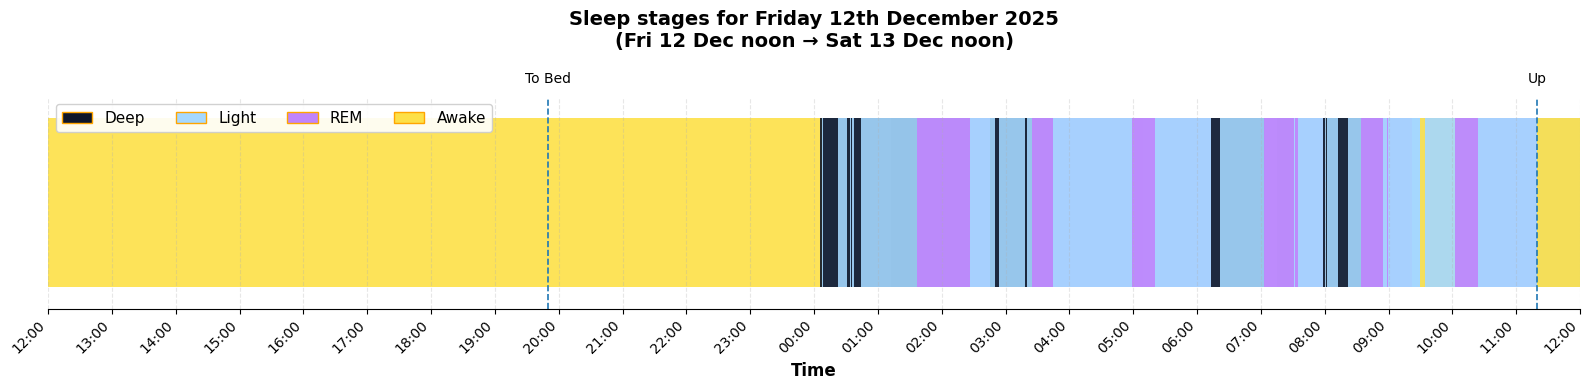


💤 Nap Analysis
----------------------------------------------------------------------
😴 No naps found

📊 Sleep Distribution
----------------------------------------------------------------------


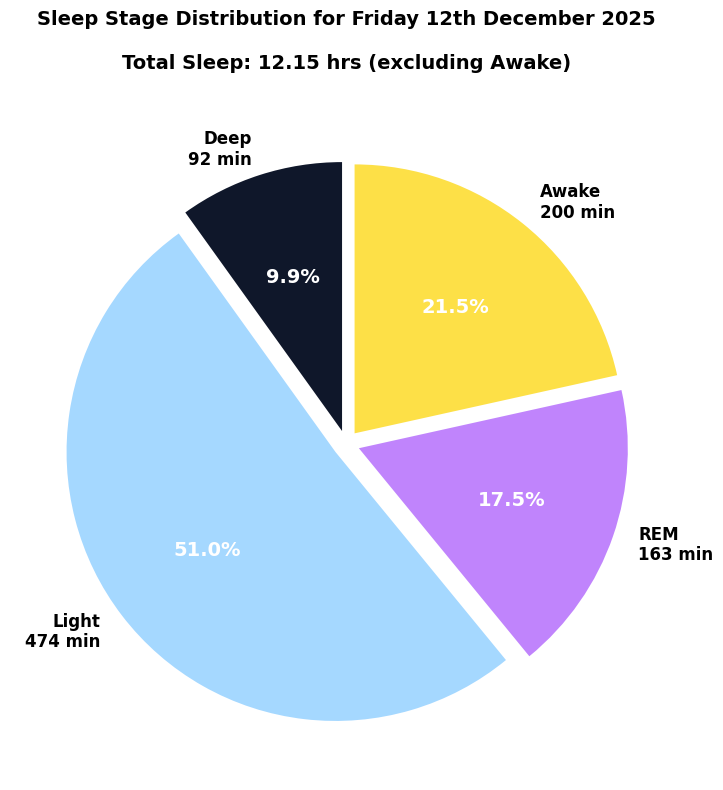


📊 Sleep Composition
----------------------------------------------------------------------


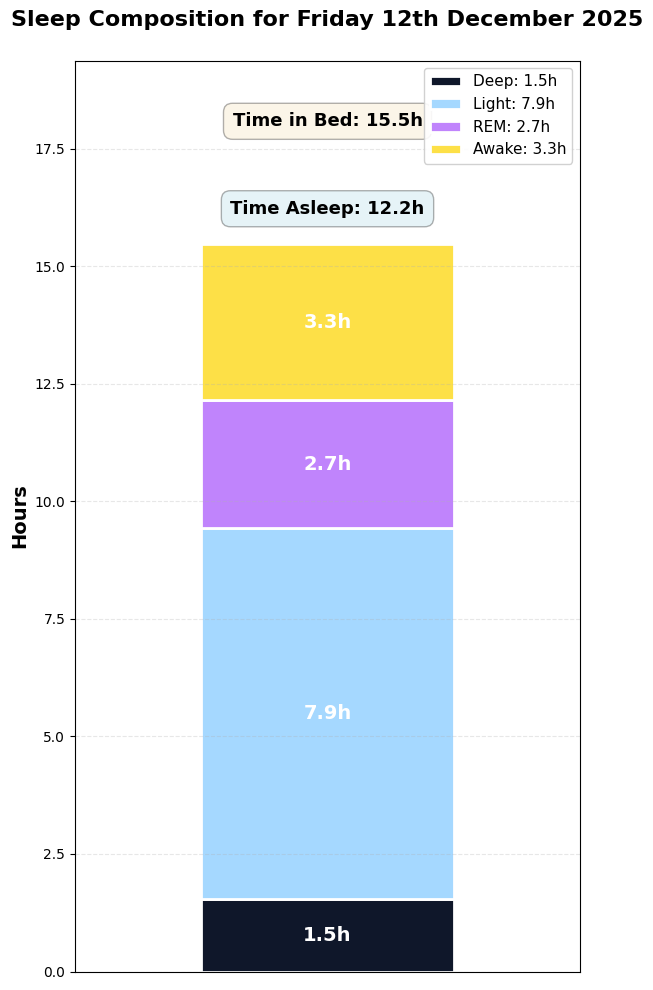


💓 Heart Rate by Sleep Stage
----------------------------------------------------------------------


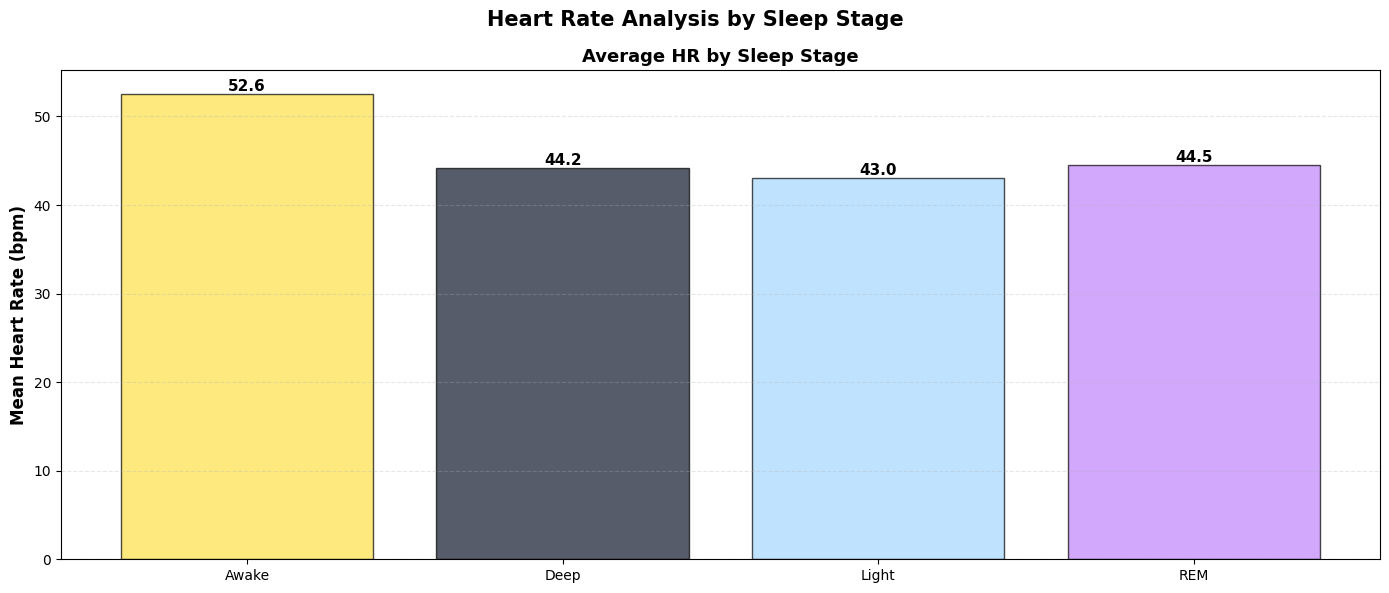

In [27]:
if ANALYSIS_MODE == 'single':
    print(f"\n{'='*70}")
    print(f"SINGLE-DAY SLEEP ANALYSIS FOR {TARGET_DATE}")
    print(f"{'='*70}\n")
    
    # Main Sleep Timeline
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n🌙 Main Sleep Timeline")
        print("-" * 70)
        fig = plot_sleep_timeline(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()
    
    # Naps
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n💤 Nap Analysis")
        print("-" * 70)
        fig = plot_naps_timeline(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()

    # Sleep Distribution
    if not df_sleep_summary.empty:
        print("\n📊 Sleep Distribution")
        print("-" * 70)
        fig = plot_sleep_stages_pie(df_sleep_levels, df_sleep_summary)
        if fig: plt.show()
    
    # Sleep Composition
    if not df_sleep_summary.empty:
        print("\n📊 Sleep Composition")
        print("-" * 70)
        fig = plot_sleep_stages_bar(df_sleep_summary)
        if fig: plt.show()
    
    # Sleep Efficiency
    # if not df_sleep_summary.empty:
    #     print("\n✨ Sleep Efficiency")
    #     print("-" * 70)
    #     fig = display_sleep_efficiency(df_sleep_summary)
    #     if fig: plt.show()
    
    # Heart Rate During Sleep
    # if not df_hr_intra.empty and not df_sleep_summary.empty:
    #     print("\n❤️ Heart Rate During Sleep")
    #     print("-" * 70)
    #     fig = plot_hr_during_sleep(df_hr_intra, df_sleep_summary, df_sleep_levels)
    #     if fig: plt.show()
    
    # HR by Sleep Stage
    if not df_hr_intra.empty and not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n💓 Heart Rate by Sleep Stage")
        print("-" * 70)
        fig = plot_hr_by_sleep_stage(df_hr_intra, df_sleep_levels, df_sleep_summary)
        if fig: plt.show()

else:
    print("ℹ️  Single-day analysis skipped (mode is 'multi')")

---
## 🔍 Multi-Day Analysis Functions

In [28]:
# ============================================================================
# MULTI-DAY SLEEP TRENDS
# ============================================================================

def plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, start_date, end_date):
    """
    Plot state timeline for multiple days showing both main sleeps and naps.
    Each day gets its own row in the timeline.
    """
    if df_sleep_levels.empty or df_sleep_summary.empty:
        print("❌ No sleep data found")
        return None

    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    num_days = len(dates)

    # Create figure with one row per day
    fig, axes = plt.subplots(num_days, 1, figsize=(18, 3 * num_days), sharex=False)
    if num_days == 1:
        axes = [axes]

    for idx, date in enumerate(dates):
        ax = axes[idx]
        date_str = date.strftime('%Y-%m-%d')

        # Define 24-hour window for this date (midnight to midnight)
        start_time = pd.Timestamp(date, tz=TIMEZONE)
        end_time = start_time + pd.Timedelta(days=1)

        # Get all sleep sessions for this date (main + naps)
        # Filter summary to get sessions that overlap with this day
        summary_for_day = df_sleep_summary.copy()
        summary_for_day['time'] = pd.to_datetime(summary_for_day['time']).dt.tz_convert(TIMEZONE)
        summary_for_day['end_time'] = pd.to_datetime(summary_for_day['end_time']).dt.tz_convert(TIMEZONE)

        # Get sessions that overlap with this day's window
        sessions = summary_for_day[
            (summary_for_day['time'] < end_time) &
            (summary_for_day['end_time'] > start_time)
        ]

        if sessions.empty:
            # No sleep data for this day
            ax.text(0.5, 0.5, 'No sleep data',
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, style='italic', color='gray')
            ax.set_xlim(start_time, end_time)
            ax.set_ylim(-0.5, 0.5)
            ax.set_yticks([])
            title = f'{date.strftime("%A, %B %d, %Y")} - No Data'
            ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            continue

        # Prepare sleep level data for this time window
        levels = _prepare_sleep_data(df_sleep_levels, df_sleep_summary, start_time, end_time)

        if not levels.empty:
            _plot_sleep_bars(ax, levels)

        # Add labels for each sleep session
        for _, session in sessions.iterrows():
            session_start = session['time']
            session_end = session['end_time']
            is_main = session.get('isMainSleep', 'True') == 'True'

            # Clip times to the current day's window for visualization
            display_start = max(session_start, start_time)
            display_end = min(session_end, end_time)

            label_text = "Main Sleep" if is_main else "Nap"
            duration_min = session.get('minutesInBed', 0)
            efficiency = session.get('efficiency', 0)

            # Add vertical line at start
            ax.axvline(display_start, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

            # Add label above the timeline
            label_y_pos = 1.1
            ax.text(display_start, label_y_pos,
                   f"{label_text}\n{display_start.strftime('%H:%M')} | {duration_min:.0f}min | {efficiency:.0f}%\n\n",
                   ha='left', va='bottom', fontsize=9, fontweight='bold',
                   transform=ax.get_xaxis_transform())

        # Format the axis for this day
        formatter = DateFormatter('%H:%M', tz=TIMEZONE)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(HourLocator(interval=2, tz=TIMEZONE))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        ax.set_xlim(start_time, end_time)
        ax.set_ylim(-0.5, 0.5)
        ax.set_yticks([])
        ax.set_xlabel('Time', fontsize=10, fontweight='bold')

        # Build title with session count
        main_count = len(sessions[sessions.get('isMainSleep', 'True') == 'True'])
        nap_count = len(sessions[sessions.get('isMainSleep', 'True') == 'False'])

        title_parts = [date.strftime("%A, %B %d, %Y")]
        if main_count > 0:
            title_parts.append(f"{main_count} main sleep")
        if nap_count > 0:
            title_parts.append(f"{nap_count} nap{'s' if nap_count > 1 else ''}")

        title = " - ".join(title_parts)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

        ax.grid(True, axis='x', alpha=0.3, linestyle='--')
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Add legend only on first plot
        if idx == 0:
            _add_sleep_legend(ax, location='upper right')

    plt.suptitle(f'Multi-Day Sleep Timeline: {start_date} to {end_date}',
                fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()

    return fig


def plot_sleep_trends(df_sleep_summary):
    """
    Plot sleep quality trends over multiple days.
    Shows efficiency, duration, and stage composition.
    """
    if df_sleep_summary.empty:
        print("❌ No sleep data")
        return None
    
    # Filter for main sleep only
    if 'isMainSleep' in df_sleep_summary.columns:
        df_main = df_sleep_summary[df_sleep_summary['isMainSleep'] == 'True'].copy()
    else:
        df_main = df_sleep_summary.copy()
    
    if df_main.empty:
        print("❌ No main sleep sessions found")
        return None
    
    # Ensure we have a date column
    if 'date' not in df_main.columns and 'time' in df_main.columns:
        df_main['date'] = pd.to_datetime(df_main['time']).dt.date
    
    df_main = df_main.sort_values('date')
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Plot 1: Sleep Efficiency
    ax1 = axes[0]
    ax1.plot(df_main['date'], df_main['efficiency'], 
             marker='o', linewidth=2, markersize=8, color='#3b82f6')
    ax1.axhline(85, color='green', linestyle='--', alpha=0.5, label='Excellent (85%)')
    ax1.axhline(75, color='orange', linestyle='--', alpha=0.5, label='Good (75%)')
    ax1.set_ylabel('Efficiency (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Sleep Efficiency Trend', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend()
    
    # Plot 2: Sleep Duration
    ax2 = axes[1]
    hours_asleep = df_main['minutesAsleep'] / 60
    hours_in_bed = df_main['minutesInBed'] / 60
    
    ax2.plot(df_main['date'], hours_asleep, 
             marker='o', linewidth=2, markersize=8, color='#10b981', label='Hours Asleep')
    ax2.plot(df_main['date'], hours_in_bed, 
             marker='s', linewidth=2, markersize=6, color='#f59e0b', 
             alpha=0.7, linestyle='--', label='Hours in Bed')
    ax2.axhline(7, color='green', linestyle='--', alpha=0.3, label='Target (7h)')
    ax2.set_ylabel('Hours', fontsize=12, fontweight='bold')
    ax2.set_title('Sleep Duration Trend', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend()
    
    # Plot 3: Sleep Stage Composition (stacked area)
    ax3 = axes[2]
    
    deep_hours = df_main['minutesDeep'] / 60
    light_hours = df_main['minutesLight'] / 60
    rem_hours = df_main['minutesREM'] / 60
    awake_hours = df_main['minutesAwake'] / 60
    
    ax3.fill_between(df_main['date'], 0, deep_hours, 
                     color=SLEEP_COLORS['Deep'], alpha=0.8, label='Deep')
    ax3.fill_between(df_main['date'], deep_hours, deep_hours + light_hours, 
                     color=SLEEP_COLORS['Light'], alpha=0.8, label='Light')
    ax3.fill_between(df_main['date'], deep_hours + light_hours, 
                     deep_hours + light_hours + rem_hours, 
                     color=SLEEP_COLORS['REM'], alpha=0.8, label='REM')
    ax3.fill_between(df_main['date'], deep_hours + light_hours + rem_hours,
                     deep_hours + light_hours + rem_hours + awake_hours,
                     color=SLEEP_COLORS['Awake'], alpha=0.8, label='Awake')
    
    ax3.set_ylabel('Hours', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax3.set_title('Sleep Stage Composition', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax3.legend(loc='upper right')
    
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle('Multi-Day Sleep Trends', fontsize=15, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig


def plot_sleep_metrics_correlation(df_sleep_summary, df_hrv, df_resting_hr):
    """
    Plot correlations between sleep quality and recovery metrics.
    """
    if df_sleep_summary.empty:
        print("❌ No sleep data")
        return None
    
    # Merge datasets
    df_merged = df_sleep_summary.copy()
    
    if not df_hrv.empty and 'date' in df_hrv.columns:
        df_merged = df_merged.merge(
            df_hrv[['date', 'dailyRmssd']], 
            on='date', 
            how='left'
        )
    
    if not df_resting_hr.empty and 'date' in df_resting_hr.columns:
        df_merged = df_merged.merge(
            df_resting_hr[['date', 'value']].rename(columns={'value': 'restingHR'}),
            on='date',
            how='left'
        )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Sleep Efficiency vs HRV
    if 'dailyRmssd' in df_merged.columns:
        ax1 = axes[0]
        ax1.scatter(df_merged['efficiency'], df_merged['dailyRmssd'], 
                   s=100, alpha=0.6, color='#3b82f6')
        ax1.set_xlabel('Sleep Efficiency (%)', fontsize=12, fontweight='bold')
        ax1.set_ylabel('HRV (RMSSD ms)', fontsize=12, fontweight='bold')
        ax1.set_title('Sleep Efficiency vs HRV', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Add trend line
        if len(df_merged.dropna(subset=['efficiency', 'dailyRmssd'])) > 1:
            z = np.polyfit(df_merged['efficiency'].dropna(), 
                          df_merged['dailyRmssd'].dropna(), 1)
            p = np.poly1d(z)
            ax1.plot(df_merged['efficiency'].sort_values(), 
                    p(df_merged['efficiency'].sort_values()),
                    "r--", alpha=0.5, linewidth=2)
    
    # Plot 2: Sleep Duration vs Resting HR
    if 'restingHR' in df_merged.columns:
        ax2 = axes[1]
        hours_asleep = df_merged['minutesAsleep'] / 60
        ax2.scatter(hours_asleep, df_merged['restingHR'], 
                   s=100, alpha=0.6, color='#10b981')
        ax2.set_xlabel('Hours Asleep', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Resting HR (bpm)', fontsize=12, fontweight='bold')
        ax2.set_title('Sleep Duration vs Resting HR', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, linestyle='--')
        
        # Add trend line
        if len(df_merged.dropna(subset=['minutesAsleep', 'restingHR'])) > 1:
            z = np.polyfit(hours_asleep.dropna(), 
                          df_merged['restingHR'].dropna(), 1)
            p = np.poly1d(z)
            ax2.plot(hours_asleep.sort_values(), 
                    p(hours_asleep.sort_values()),
                    "r--", alpha=0.5, linewidth=2)
    
    plt.suptitle('Sleep Quality & Recovery Metrics Correlation', 
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    
    return fig


# ============================================================================
# ACTIVITY PATTERN ANALYSIS
# ============================================================================

def plot_hourly_activity_heatmap(df_steps_intra, tz='Europe/London'):
    """
    Show hourly activity levels as a heatmap-style bar chart.
    
    Args:
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    if df_steps_intra.empty:
        print("⚠️  No steps data available")
        return None
    
    # Convert to local timezone
    df_steps = df_steps_intra.copy()
    if df_steps['time'].dt.tz is not None:
        df_steps['time'] = df_steps['time'].dt.tz_convert(tz)
    
    # Extract date and hour
    date_str = df_steps['time'].iloc[0].strftime('%A, %dth %B')
    df_steps['hour'] = df_steps['time'].dt.hour
    
    # Calculate steps per hour
    hourly_steps = df_steps.groupby('hour', as_index=False)['value'].sum()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure all 24 hours are present
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create color map based on activity level
    max_steps = hourly_steps['steps'].max()
    if max_steps > 0:
        colors = plt.cm.YlOrRd(hourly_steps['steps'] / max_steps)
    else:
        colors = ['lightgray'] * 24
    
    # Plot bars
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar, steps in zip(bars, hourly_steps['steps']):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(steps)}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Steps', fontsize=12, fontweight='bold')
    ax.set_title(f'Hourly Activity Distribution for {date_str}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    return fig


print("✅ Multi-day analysis and activity pattern functions defined")

✅ Multi-day analysis and activity pattern functions defined


---
## 📈 Multi-Day Analysis

In [29]:
if ANALYSIS_MODE == 'multi':
    print(f"\n{'='*70}")
    print(f"MULTI-DAY SLEEP ANALYSIS: {START_DATE} to {END_DATE}")
    print(f"{'='*70}\n")
    
    # Multi-Day Sleep Timeline (Main Sleeps + Naps)
    if not df_sleep_levels.empty and not df_sleep_summary.empty:
        print("\n🌙 Multi-Day Sleep State Timeline")
        print("-" * 70)
        print("Shows all sleep sessions (main sleeps and naps) across multiple days\n")
        fig = plot_multi_day_sleep_timeline(df_sleep_levels, df_sleep_summary, START_DATE, END_DATE)
        if fig: plt.show()
    else:
        print("❌ Insufficient data for multi-day timeline")

else:
    print("ℹ️  Multi-day analysis skipped (mode is 'single')")

ℹ️  Multi-day analysis skipped (mode is 'single')



👟 Hourly Activity Distribution
----------------------------------------------------------------------


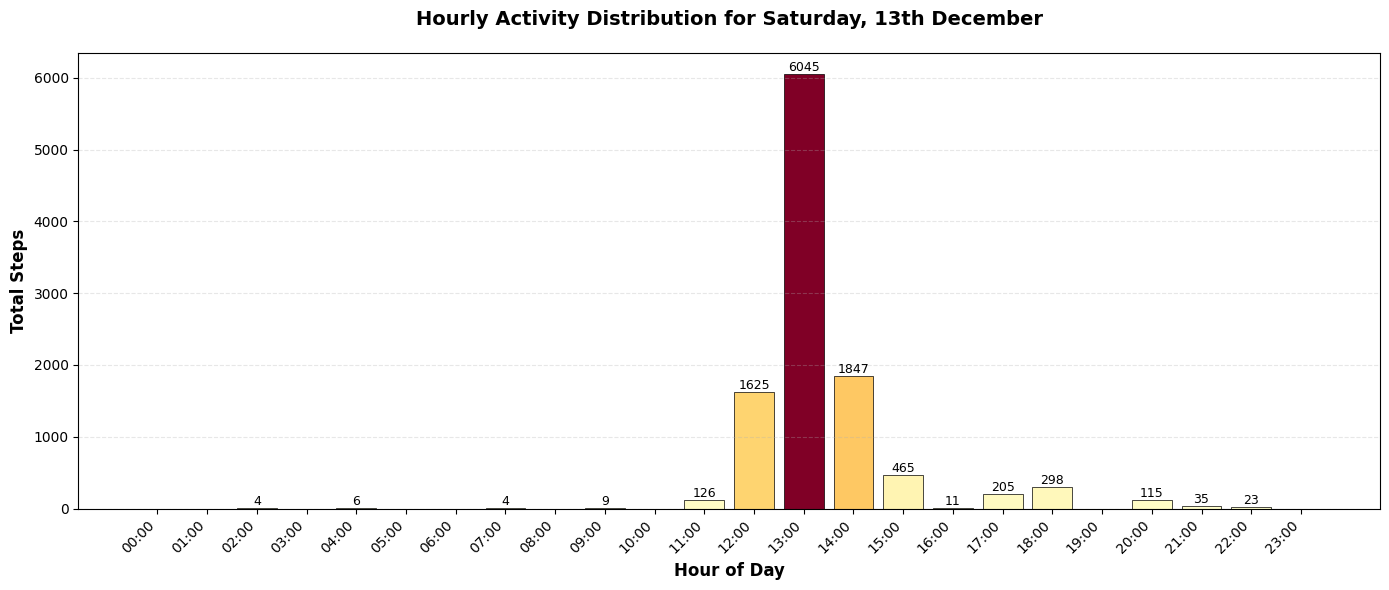

In [30]:
# Load steps data if not already loaded
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())

if not df_steps_intra.empty:
    print("\n👟 Hourly Activity Distribution")
    print("-" * 70)
    fig = plot_hourly_activity_heatmap(df_steps_intra, TIMEZONE)
    if fig: plt.show()
else:
    print("⚠️  No steps data available for hourly activity heatmap")

---
## 👟 Activity Pattern Analysis

Hourly activity distribution showing step patterns throughout the day.

---
## 📝 Notes

Add your observations here:
- 
- 
- 